# Assignment 2 - Implement your agent

Welcome to Course 4, Programming Assignment 2! We have learned about reinforcement learning algorithms for prediction and control in previous courses and extended those algorithms to large state spaces using function approximation. One example of this was in assignment 2 of course 3 where we implemented semi-gradient TD for prediction and used a neural network as the function approximator. In this notebook, we will build a reinforcement learning agent for control, again using a neural network for function approximation. This combination of neural network function approximators and reinforcement learning algorithms, often referred to as Deep RL, is an active area of research and has led to many impressive results (e. g., AlphaGo: https://deepmind.com/research/case-studies/alphago-the-story-so-far).

**In this assignment, you will:**
  1. Extend the neural network code from assignment 2 of course 3 to output action-values instead of state-values.
  2. Write up the Adam algorithm for neural network optimization.
  3. Understand experience replay buffers.
  4. Implement Softmax action-selection.
  5. Build an Expected Sarsa agent by putting all the pieces together.
  6. Solve Lunar Lander with your agent.

## Packages
- [numpy](www.numpy.org) : Fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) : Library for plotting graphs in Python.
- [RL-Glue](http://www.jmlr.org/papers/v10/tanner09a.html), BaseEnvironment, BaseAgent : Library and abstract classes to inherit from  for reinforcement learning experiments.
- [LunarLanderEnvironment](https://gym.openai.com/envs/LunarLander-v2/) : An RLGlue environment that wraps a LundarLander environment implementation from OpenAI Gym.
- [collections.deque](https://docs.python.org/3/library/collections.html#collections.deque): a double-ended queue implementation. We use deque to implement the experience replay buffer.
- [copy.deepcopy](https://docs.python.org/3/library/copy.html#copy.deepcopy): As objects are not passed by value in python, we often need to make copies of mutable objects. copy.deepcopy allows us to make a new object with the same contents as another object. (Take a look at this link if you are interested to learn more: https://robertheaton.com/2014/02/09/pythons-pass-by-object-reference-as-explained-by-philip-k-dick/)
- [tqdm](https://github.com/tqdm/tqdm) : A package to display progress bar when running experiments
- [os](https://docs.python.org/3/library/os.html): Package used to interface with the operating system. Here we use it for creating a results folder when it does not exist.
- [shutil](https://docs.python.org/3/library/shutil.html): Package used to operate on files and folders. Here we use it for creating a zip file of the results folder.
- plot_script: Used for plotting learning curves using matplotlib.

In [1]:
# Do not modify this cell!

# Import necessary libraries
# DO NOT IMPORT OTHER LIBRARIES - This will break the autograder.
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from rl_glue import RLGlue
from environment import BaseEnvironment
from agent import BaseAgent

from lunar_lander import LunarLanderEnvironment


from collections import deque

from copy import deepcopy

from tqdm import tqdm
from tqdm import trange

import os 

import shutil

from plot_script import plot_result

import torch
import torch.nn.functional as F
from policy import Policy
import torch.optim as optim
import torch.nn as nn

import gym

import pdb

import time

## Section 1: Action-Value Network
This section includes the function approximator that we use in our agent, a neural network. In Course 3 Assignment 2, we used a neural network as the function approximator for a policy evaluation problem. In this assignment, we will use a neural network for approximating the action-value function in a control problem. The main difference between approximating a state-value function and an action-value function using a neural network is that in the former the output layer only includes one unit whereas in the latter the output layer includes as many units as the number of actions. 

In the cell below, you will specify the architecture of the action-value neural network. More specifically, you will specify `self.layer_size` in the `__init__()` function. 

We have already provided `get_action_values()` and `get_TD_update()` methods. The former computes the action-value function by doing a forward pass and the latter computes the gradient of the action-value function with respect to the weights times the TD error. These `get_action_values()` and `get_TD_update()` methods are similar to the `get_value()` and `get_gradient()` methods that you implemented in Course 3 Assignment 2. The main difference is that in this notebook, they are designed to be applied to batches of states instead of one state. You will later use these functions for implementing the agent.

Run the cell below to test your implementation of the `__init__()` function for ActionValueNetwork:

**Expected output:**

    layer_sizes: [ 5 20  3]

## Section 2: Adam Optimizer

In this assignment, you will use the Adam algorithm for updating the weights of your action-value network. As you may remember from Course 3 Assignment 2, the Adam algorithm is a more advanced variant of stochastic gradient descent (SGD). The Adam algorithm improves the SGD update with two concepts: adaptive vector stepsizes and momentum. It keeps running estimates of the mean and second moment of the updates, denoted by $\mathbf{m}$ and $\mathbf{v}$ respectively:
$$\mathbf{m_t} = \beta_m \mathbf{m_{t-1}} + (1 - \beta_m)g_t \\
\mathbf{v_t} = \beta_v \mathbf{v_{t-1}} + (1 - \beta_v)g^2_t
$$

Here, $\beta_m$ and $\beta_v$ are fixed parameters controlling the linear combinations above and $g_t$ is the update at time $t$ (generally the gradients, but here the TD error times the gradients).

Given that $\mathbf{m}$ and $\mathbf{v}$ are initialized to zero, they are biased toward zero. To get unbiased estimates of the mean and second moment, Adam defines $\mathbf{\hat{m}}$ and $\mathbf{\hat{v}}$ as:
$$ \mathbf{\hat{m}_t} = \frac{\mathbf{m_t}}{1 - \beta_m^t} \\
\mathbf{\hat{v}_t} = \frac{\mathbf{v_t}}{1 - \beta_v^t}
$$

The weights are then updated as follows:
$$ \mathbf{w_t} = \mathbf{w_{t-1}} + \frac{\alpha}{\sqrt{\mathbf{\hat{v}_t}}+\epsilon} \mathbf{\hat{m}_t}
$$

Here, $\alpha$ is the step size parameter and $\epsilon$ is another small parameter to keep the denominator from being zero.

In the cell below, you will implement the `__init__()` and `update_weights()` methods for the Adam algorithm. In `__init__()`, you will initialize `self.m` and `self.v`. In `update_weights()`, you will compute new weights given the input weights and an update $g$ (here `td_errors_times_gradients`) according to the equations above.

Run the following code to test your implementation of the `__init__()` function:

**Expected output:**

    m[0]["W"] shape: (5, 2)
    m[0]["b"] shape: (1, 2)
    m[1]["W"] shape: (2, 3)
    m[1]["b"] shape: (1, 3) 

    v[0]["W"] shape: (5, 2)
    v[0]["b"] shape: (1, 2)
    v[1]["W"] shape: (2, 3)
    v[1]["b"] shape: (1, 3) 

Run the following code to test your implementation of the `update_weights()` function:

## Section 3: Experience Replay Buffers

In Course 3, you implemented agents that update value functions once for each sample. We can use a more efficient approach for updating value functions. You have seen an example of an efficient approach in Course 2 when implementing Dyna. The idea behind Dyna is to learn a model using sampled experience, obtain simulated experience from the model, and improve the value function using the simulated experience.

Experience replay is a simple method that can get some of the advantages of Dyna by saving a buffer of experience and using the data stored in the buffer as a model. This view of prior data as a model works because the data represents actual transitions from the underlying MDP. Furthermore, as a side note, this kind of model that is not learned and simply a collection of experience can be called non-parametric as it can be ever-growing as opposed to a parametric model where the transitions are learned to be represented with a fixed set of parameters or weights.

We have provided the implementation of the experience replay buffer in the cell below. ReplayBuffer includes two main functions: `append()` and `sample()`. `append()` adds an experience transition to the buffer as an array that includes the state, action, reward, terminal flag (indicating termination of the episode), and next_state. `sample()` gets a batch of experiences from the buffer with size `minibatch_size`.

You will use the `append()` and `sample()` functions when implementing the agent.

In [13]:
torch.manual_seed(1) # set random seed
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
network = Policy(s_size=8, h_size=256, a_size=4).to(device)

# Remove the following 3 lines to train the agent from scratch
model_path = 'action_value_network/action_value_network_300.pth'  # model to load
checkpoint = torch.load(model_path)
network.load_state_dict(checkpoint)

optimizer = optim.Adam(network.parameters(), lr=0.001,betas = [0.99,0.999],eps = 1e-04)

In [14]:
# Do not modify this cell! 

# Work Required: No. However, do go through the code to ensure your understanding is correct.

class ReplayBuffer:
    def __init__(self, size, minibatch_size, seed):
        """
        Args:
            size (integer): The size of the replay buffer.              
            minibatch_size (integer): The sample size.
            seed (integer): The seed for the random number generator. 
        """
        self.buffer = []
        self.minibatch_size = minibatch_size
        self.rand_generator = np.random.RandomState(seed)
        self.max_size = size

    def append(self, state, action, reward, terminal, next_state):
        """
        Args:
            state (Numpy array): The state.              
            action (integer): The action.
            reward (float): The reward.
            terminal (integer): 1 if the next state is a terminal state and 0 otherwise.
            next_state (Numpy array): The next state.           
        """
        if len(self.buffer) == self.max_size:
            del self.buffer[0]
#         self.buffer.append([state, action, reward, terminal, next_state])
#         self.buffer.append((torch.tensor(state), torch.tensor(action).to(device), torch.tensor(reward).float().to(device),torch.tensor(terminal).to(device), torch.tensor(next_state)))
        self.buffer.append((state, torch.tensor(action).to(device), torch.tensor(reward).float().to(device),torch.tensor(terminal).to(device), next_state))
    

    def sample(self):
        """
        Returns:
            A list of transition tuples including state, action, reward, terinal, and next_state
        """
        idxs = self.rand_generator.choice(np.arange(len(self.buffer)), size=self.minibatch_size)
        return [self.buffer[idx] for idx in idxs]

    def size(self):
        return len(self.buffer)

Run the cell below to test your implementation of the `softmax()` function:

**Expected output:**

    action_probs [[0.25849645 0.01689625 0.05374514 0.67086216]
     [0.84699852 0.00286345 0.13520063 0.01493741]]

## Section 5: Putting the pieces together

In this section, you will combine components from the previous sections to write up an RL-Glue Agent. The main component that you will implement is the action-value network updates with experience sampled from the experience replay buffer.

At time $t$, we have an action-value function represented as a neural network, say $Q_t$. We want to update our action-value function and get a new one we can use at the next timestep. We will get this $Q_{t+1}$ using multiple replay steps that each result in an intermediate action-value function $Q_{t+1}^{i}$ where $i$ indexes which replay step we are at.

In each replay step, we sample a batch of experiences from the replay buffer and compute a minibatch Expected-SARSA update. Across these N replay steps, we will use the current "un-updated" action-value network at time $t$, $Q_t$, for computing the action-values of the next-states. This contrasts using the most recent action-values from the last replay step $Q_{t+1}^{i}$. We make this choice to have targets that are stable across replay steps. Here is the pseudocode for performing the updates:

$$
\begin{align}
& Q_t \leftarrow \text{action-value network at timestep t (current action-value network)}\\
& \text{Initialize } Q_{t+1}^1 \leftarrow Q_t\\
& \text{For } i \text{ in } [1, ..., N] \text{ (i.e. N} \text{  replay steps)}:\\
& \hspace{1cm} s, a, r, t, s'
\leftarrow \text{Sample batch of experiences from experience replay buffer} \\
& \hspace{1cm} \text{Do Expected Sarsa update with } Q_t: Q_{t+1}^{i+1}(s, a) \leftarrow Q_{t+1}^{i}(s, a) + \alpha \cdot \left[r + \gamma \left(\sum_{b} \pi(b | s') Q_t(s', b)\right) - Q_{t+1}^{i}(s, a)\right]\\
& \hspace{1.5cm} \text{ making sure to add the } \gamma \left(\sum_{b} \pi(b | s') Q_t(s', b)\right) \text{ for non-terminal transitions only.} \\
& \text{After N replay steps, we set } Q_{t+1}^{N} \text{ as } Q_{t+1} \text{ and have a new } Q_{t+1} \text{for time step } t + 1 \text{ that we will fix in the next set of updates. }
\end{align}
$$

As you can see in the pseudocode, after sampling a batch of experiences, we do many computations. The basic idea however is that we are looking to compute a form of a TD error. In order to so, we can take the following steps:
- compute the action-values for the next states using the action-value network $Q_{t}$,
- compute the policy $\pi(b | s')$ induced by the action-values $Q_{t}$ (using the softmax function you implemented before),
- compute the Expected sarsa targets $r + \gamma \left(\sum_{b} \pi(b | s') Q_t(s', b)\right)$,
- compute the action-values for the current states using the latest $Q_{t + 1}$, and,
- compute the TD-errors with the Expected Sarsa targets.
 
For the third step above, you can start by computing $\pi(b | s') Q_t(s', b)$ followed by summation to get $\hat{v}_\pi(s') = \left(\sum_{b} \pi(b | s') Q_t(s', b)\right)$. $\hat{v}_\pi(s')$ is an estimate of the value of the next state. Note for terminal next states, $\hat{v}_\pi(s') = 0$. Finally, we add the rewards to the discount times $\hat{v}_\pi(s')$.

You will implement these steps in the `get_td_error()` function below which given a batch of experiences (including states, next_states, actions, rewards, terminals), fixed action-value network (current_q), and action-value network (network), computes the TD error in the form of a 1D array of size batch_size.

Run the following code to test your implementation of the `get_td_error()` function:

Now that you implemented the `get_td_error()` function, you can use it to implement the `optimize_network()` function. In this function, you will:
- get the TD-errors vector from `get_td_error()`,
- make the TD-errors into a matrix using zeroes for actions not taken in the transitions,
- pass the TD-errors matrix to the `get_TD_update()` function of network to calculate the gradients times TD errors, and,
- perform an ADAM optimizer step.

In [15]:
def optimize_network(experiences, discount, current_model, tau):
    
    """
    Calculate the TD-error and update the network
    
    """
    model=network
    optimizer.zero_grad()
    
    states, actions, rewards, terminals, next_states = map(list, zip(*experiences))
    
#     print(next_states)
    q_next = current_model.get_action_values(torch.stack(next_states)).squeeze()
    probs = current_model.forward(torch.stack(next_states)).squeeze()

    # calculate the maximum action value of next states
#     expected_q_next = (1-torch.stack(terminals)) * (torch.sum(probs * q_next , axis = 1))
    max_q_next = (1-torch.stack(terminals)) * (torch.max(q_next , axis = 1)[0])
    # calculate the targets  0%|          | 0/600 [00:00<?, ?it/s]<ipython-input-24-1f85acab5351>:30:
    
    rewards = torch.stack(rewards)
#     targets = Variable(rewards + (discount * expected_q_next)).float()
    targets = (rewards + (discount * max_q_next))
    
    # calculate the outputs from the previous states (batch_size, num_actions)
    outputs = network.get_action_values(torch.stack(states)).squeeze()
    
    actions = torch.stack(actions).view(-1,1)
    
    outputs = torch.gather(outputs, 1, actions).squeeze()
    
    # the loss
#     pdb.set_trace()  
    loss = torch.sum((targets-outputs)**2,axis=0)/rewards.shape[0]
       
    loss.backward()
    
    # update
    optimizer.step()

Run the following code to test your implementation of the `optimize_network()` function:

Now that you implemented the `optimize_network()` function, you can implement the agent. In the cell below, you will fill the `agent_step()` and `agent_end()` functions. You should:
- select an action (only in `agent_step()`),
- add transitions (consisting of the state, action, reward, terminal, and next state) to the replay buffer, and,
- update the weights of the neural network by doing multiple replay steps and calling the `optimize_network()` function that you implemented above.

In [16]:
### Work Required: Yes. Fill in code in agent_step and agent_end (~7 Lines).
class Agent(BaseAgent):
    def __init__(self):
        self.name = "expected_sarsa_agent"
        
    # Work Required: No.
    def agent_init(self, agent_config):
        """Setup for the agent called when the experiment first starts.

        Set parameters needed to setup the agent.

        Assume agent_config dict contains:
        {
            network_config: dictionary,
            optimizer_config: dictionary,
            replay_buffer_size: integer,
            minibatch_sz: integer, 
            num_replay_updates_per_step: float
            discount_factor: float,
        }
        """
        
        
        self.replay_buffer = ReplayBuffer(agent_config['replay_buffer_size'], 
                                          agent_config['minibatch_sz'], agent_config.get("seed"))
        

        self.num_actions = agent_config['network_config']['num_actions']
        self.num_replay = agent_config['num_replay_updates_per_step']
        self.discount = agent_config['gamma']
        self.tau = agent_config['tau']
        
        self.rand_generator = np.random.RandomState(agent_config.get("seed"))
        
        self.last_state = None
        self.last_action = None
        
        self.sum_rewards = 0
        self.episode_steps = 0

    # Work Required: No.
    def policy(self, state):
        """
        Args:
            state (Numpy array): the state.
        Returns:
            the action. 
        """
#         action_values = self.network.get_action_values(state)
#         probs_batch = softmax(action_values, self.tau)
#         action = self.rand_generator.choice(self.num_actions, p=probs_batch.squeeze())
        action = network.act(state)
#         print(action)
        return action

    # Work Required: No.
    def agent_start(self, state):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            state (Numpy array): the state from the
                environment's evn_start function.
        Returns:
            The first action the agent takes.
        """
        self.sum_rewards = 0
        self.episode_steps = 0
#         self.last_state = np.array([state])
        state = torch.tensor([state]).view(1, -1)
        self.last_state = state.to(device)
        self.last_action = self.policy(self.last_state)
        return self.last_action

    # Work Required: Yes. Fill in the action selection, replay-buffer update, 
    # weights update using optimize_network, and updating last_state and last_action (~5 lines).
    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (Numpy array): the state from the
                environment's step based, where the agent ended up after the
                last step
        Returns:
            The action the agent is taking.
        """
        
        self.sum_rewards += reward
        self.episode_steps += 1

        # Make state an array of shape (1, state_dim) to add a batch dimension and
        # to later match the get_action_values() and get_TD_update() functions
#         state = np.array([state])
        state = torch.tensor([state]).view(1, -1).to(device)

        # Select action
        ### START CODE HERE (~1 Line)
        action = self.policy(state)
        ### END CODE HERE
        
        # Append new experience to replay buffer
        # Note: look at the replay_buffer append function for the order of arguments

        ### START CODE HERE (~1 Line)
        self.replay_buffer.append(self.last_state, self.last_action, reward,  0, state)
        ### END CODE HERE
        
        # Perform replay steps:
        if self.replay_buffer.size() > self.replay_buffer.minibatch_size:
            current_q = deepcopy(network).to(device)
#             for paramss in current_q.parameters():
#                 paramss.requires_grad = False     
#             current_q.eval()                
                
            for _ in range(self.num_replay):
                
                # Get sample experiences from the replay buffer
                experiences = self.replay_buffer.sample()
                
                # Call optimize_network to update the weights of the network (~1 Line)
                ### START CODE HERE
                optimize_network(experiences, self.discount, current_q, self.tau)

                ### END CODE HERE
                
        # Update the last state and last action.
        ### START CODE HERE (~2 Lines)
        self.last_state = state
        self.last_action = int(action)
        ### END CODE HERE
        
        return action

    # Work Required: Yes. Fill in the replay-buffer update and
    # update of the weights using optimize_network (~2 lines).
    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        self.sum_rewards += reward
        self.episode_steps += 1
        
        # Set terminal state to an array of zeros
#         state = np.zeros_like(self.last_state)
        state = torch.zeros_like(self.last_state).to(device)

        # Append new experience to replay buffer
        # Note: look at the replay_buffer append function for the order of arguments
        
        ### START CODE HERE (~1 Line)
        self.replay_buffer.append(self.last_state, self.last_action, reward, 1, state)
        ### END CODE HERE
        
        # Perform replay steps:
        if self.replay_buffer.size() > self.replay_buffer.minibatch_size:
            current_q = deepcopy(network)
#             for paramss in current_q.parameters():
#                 paramss.requires_grad = False
                
            for _ in range(self.num_replay):
                
                # Get sample experiences from the replay buffer
                experiences = self.replay_buffer.sample()
                
                # Call optimize_network to update the weights of the network
                ### START CODE HERE (~1 Line)
                optimize_network(experiences, self.discount, current_q, self.tau)
                               
                ### END CODE HERE
                
        
    def agent_message(self, message):
        if message == "get_sum_reward":
            return self.sum_rewards
        else:
            raise Exception("Unrecognized Message!")

Run the following code to test your implementation of the `agent_step()` function:

Run the following code to test your implementation of the `agent_end()` function:

## Section 6: Run Experiment

Now that you implemented the agent, we can use it to run an experiment on the Lunar Lander problem. We will plot the learning curve of the agent to visualize learning progress. To plot the learning curve, we use the sum of rewards in an episode as the performance measure. We have provided for you the experiment/plot code in the cell below which you can go ahead and run. Note that running the cell below has taken approximately 10 minutes in prior testing.

In [17]:
def run_experiment(environment, agent, environment_parameters, agent_parameters, experiment_parameters):
    
    rl_glue = RLGlue(environment, agent)
        
    # save sum of reward at the end of each episode
    agent_sum_reward = np.zeros((experiment_parameters["num_runs"], 
                                 experiment_parameters["num_episodes"]))

    env_info = {}

    agent_info = agent_parameters

    # one agent setting
    for run in range(1, experiment_parameters["num_runs"]+1):
        agent_info["seed"] = run
        agent_info["network_config"]["seed"] = run
        env_info["seed"] = run

        rl_glue.rl_init(agent_info, env_info)
        
        with trange(1, experiment_parameters["num_episodes"]+1) as t:
            for episode in t:
        
#         for episode in tqdm(range(1, experiment_parameters["num_episodes"]+1)):
                # run episode
                rl_glue.rl_episode(experiment_parameters["timeout"])

                episode_reward = rl_glue.rl_agent_message("get_sum_reward")
                agent_sum_reward[run - 1, episode - 1] = episode_reward
                t.set_description('episode_sum %f' % episode_reward)
#                 t.set_postfix("episode_reward = %i" % episode_reward)
#                 sleep(0.1)
                
#                 if episode%10==0
#                     print("Episode Reward sum", episode_reward)
    
    
    torch.save(network.state_dict(),'action_value_network/action_value_network_{}.pth'.format(experiment_parameters["num_episodes"]))
    
    save_name = "{}".format(rl_glue.agent.name)
    if not os.path.exists('results'):
        os.makedirs('results')
    np.save("results/sum_reward_{}".format(save_name), agent_sum_reward)
    shutil.make_archive('results', 'zip', 'results')

# Run Experiment

# Experiment parameters
experiment_parameters = {
    "num_runs" : 1,
    "num_episodes" : 500,
    # OpenAI Gym environments allow for a timestep limit timeout, causing episodes to end after 
    # some number of timesteps. Here we use the default of 1000.
    "timeout" : 1000
}

# Environment parameters
environment_parameters = {}

current_env = LunarLanderEnvironment

# Agent parameters
agent_parameters = {
    'network_config': {
        'state_dim': 8,
        'num_hidden_units': 256,
        'num_actions': 4
    },
    'optimizer_config': {
        'step_size': 1e-3,
        'beta_m': 0.9, 
        'beta_v': 0.999,
        'epsilon': 1e-8
    },
    'replay_buffer_size': 50000,
    'minibatch_sz': 8,
    'num_replay_updates_per_step': 4,
    'gamma': 0.99,
    'tau': 0.001
}
current_agent = Agent

# run experiment
run_experiment(current_env, current_agent, environment_parameters, agent_parameters, experiment_parameters)

episode_sum 209.860415: 100%|██████████| 500/500 [53:28<00:00,  6.42s/it] 


Run the cell below to see the comparison between the agent that you implemented and a random agent for the one run and 300 episodes. Note that the `plot_result()` function smoothes the learning curve by applying a sliding window on the performance measure. 

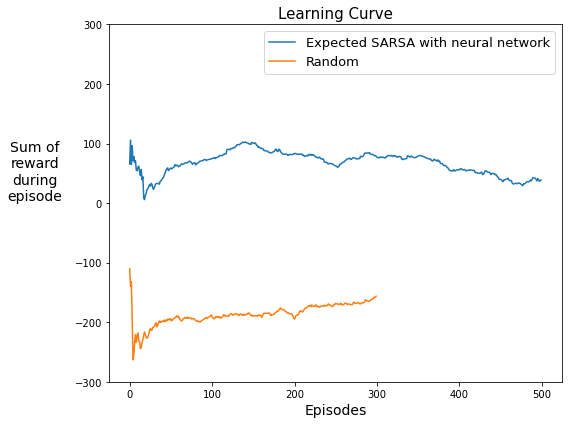

In [18]:
plot_result(["expected_sarsa_agent", "random_agent"])

In the following cell you can visualize the performance of the agent with a correct implementation. As you can see, the agent initially crashes quite quickly (Episode 0). Then, the agent learns to avoid crashing by expending fuel and staying far above the ground. Finally however, it learns to land smoothly within the landing zone demarcated by the two flags (Episode 275).

In [19]:
%%HTML
<div align="middle">
<video width="80%" controls>
      <source src="ImplementYourAgent.mp4" type="video/mp4">
</video></div>

Testing the Agent

In [2]:
torch.manual_seed(1) # set random seed
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
network = Policy(s_size=8, h_size=256, a_size=4).to(device)

model_path = 'action_value_network/action_value_network_500.pth'  # model to load
checkpoint = torch.load(model_path)
network.load_state_dict(checkpoint)

<All keys matched successfully>

In [3]:
env = gym.make("LunarLander-v2")
num_episodes = 20

for i in range(num_episodes):
    state=env.reset()
    state=torch.from_numpy(state).to(device).view(1, -1)
    is_terminal=False 
    env.render()
    sum_reward=0
    
    while not is_terminal: 
        action = network.act(state)
        current_state, reward, is_terminal, _ = env.step(action)
        env.render()
        state=torch.from_numpy(current_state).to(device).view(1, -1)
        time.sleep(0.02)
        sum_reward=sum_reward+reward
    
    print("Total reward obtained in this episode is {}".format(sum_reward))
    env.close()   
    
    

Total reward obtained in this episode is 109.41931301243477
Total reward obtained in this episode is 120.15328935951902
Total reward obtained in this episode is 171.14828142129022
Total reward obtained in this episode is 116.41236106887
Total reward obtained in this episode is 109.07608108539932


KeyboardInterrupt: 